In [124]:
def InitialSetup():
  #%%javascript
  %pip uninstall --y torch torchvision
  %pip install --pre torchvision -f  https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
  %pip install av

In [125]:
import torch
print(torch.__version__)
if torch.__version__ == '1.10.0+cu111':
  
  from google.colab import drive
  drive.mount('/content/drive')
  InitialSetup()

1.11.0+cu102


In [126]:
import numpy as np
import torch
import os
import sys
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
import tempfile

from glob import glob
from PIL import Image
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from urllib.request import urlretrieve
from torchvision.io import read_video
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import raft
from torchvision.utils import flow_to_image
from torchvision.transforms import ToTensor

In [127]:
im1 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP000L1S20120322T114453.tif")
im2 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP045L1S20120322T114453.tif")
im3 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP090L1S20120322T114453.tif")
im4 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP135L1S20120322T114453.tif")
im5 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP180L1S20120322T114453.tif")
im6 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP225L1S20120322T114453.tif")
im7 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP270L1S20120322T114453.tif")
im8 = Image.open("/content/drive/MyDrive/Coch_data/Image_F10HzP315L1S20120322T114453.tif")
num_im = 8

In [128]:
def crop_image(i):
    return i.crop((0,0,1600,600))

im1 = crop_image(im1)
im2 = crop_image(im2)
im3 = crop_image(im3)
im4 = crop_image(im4)
im5 = crop_image(im5)
im6 = crop_image(im6)
im7 = crop_image(im7)
im8 = crop_image(im8)

In [129]:
def get_im(i):
        i+=1
        if i== 1:
            return im1
        if i== 2:
            return im2
        if i== 3:
            return im3
        if i== 4:
            return im4
        if i== 5:
            return im5
        if i== 6:
            return im6
        if i== 7:
            return im7
        if i== 8:
            return im8
        else :
            return 'Whoops'

In [130]:
# convert image to tensor
def img_totensor(i):
  return ToTensor()(get_im(i))

In [131]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")    

In [132]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

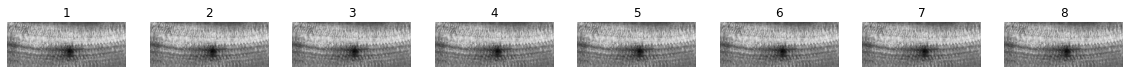

In [133]:
#PLOTTING IMAGES
rows = 1
columns = 8

fig = plt.figure(figsize=(20, 10))

for i in range(num_im):
  fig.add_subplot(rows, columns, i+1)
  im = get_im(i)
  plt.imshow(im, cmap='gray')
  #plt.imshow(im)
  plt.axis('off')
  plt.title(str(i+1))

In [134]:
imarray1 = np.array(im1)
imarray2 = np.array(im2)
print(imarray1.shape)
print(imarray2.shape)
print(im1.size)
print(im2.size)

(600, 1600)
(600, 1600)
(1600, 600)
(1600, 600)


In [135]:
#@title Obsolete?
# #Setting up for a for loop:
# gridlist=[]

# for i in range(7): #change to range(1) to only run once
#   #we'll end up with seven of these for im1 + im2, im2 + im3, etc...
#   img1_batch=ToTensor()(get_im(i))
#   img2_batch=ToTensor()(get_im(i+1))
#   img3_batch = torch.stack([img1_batch, img2_batch])
#   img4_batch = torch.stack([img1_batch, img2_batch])
#   def preprocess(batch):
#       transforms = T.Compose(
#           [
#               T.ConvertImageDtype(torch.float32),
#               T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
#               T.Resize(size=(128, 128)),
#           ]
#       )
#       batch = transforms(batch)
#       return batch


#   # If you can, run this example on a GPU, it will be a lot faster.
#   device = "cuda" if torch.cuda.is_available() else "cpu"

#   img1_batch_t = preprocess(img3_batch).to(device)
#   img2_batch_t = preprocess(img4_batch).to(device)

#   #print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

#   img1_batch_t = img1_batch_t.repeat(1,3,1,1)
#   img2_batch_t = img2_batch_t.repeat(1,3,1,1)
#   #print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
#   #img1_batch_t=img1_batch_t[None,:, :,:]
#   #img2_batch_t=img2_batch_t[None,:, :,:]

#   #print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
#   #print(f"shape = {img2_batch_t.shape}, dtype = {img2_batch_t.dtype}")

#   #print(f"shape = {img2_batch.shape}, dtype = {img2_batch.dtype}")
#   model = raft_small(pretrained=True, progress=False).to(device)
#   #model_summary(model)
#   #model_vals=[layer for layer in model.parameters()]
#   #print(model_vals)
#   #print(model.parameters)
#   model = model.eval()

#   list_of_flows = model(img1_batch_t.to(device), img2_batch_t.to(device))
#   #print(f"type = {type(list_of_flows)}")
#   #print(f"length = {len(list_of_flows)} = number of iterations of the model")
#   predicted_flows = list_of_flows[-1]
#   #print(f"dtype = {predicted_flows.dtype}")
#   #print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
#   #print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

#   flow_imgs = flow_to_image(predicted_flows)

#   # The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
#   img1_batch = [(img1 + 1) / 2 for img1 in img1_batch_t]

#   #grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
#   grid=[img1_batch[0], flow_imgs[0]]
#   gridlist.append(grid)
#   #plot(grid)

# grid=[img1_batch[0+1], flow_imgs[0+1]]
# gridlist.append(grid)

# transposed_tuples = list(zip(*gridlist))
# transposed = [list(sublist) for sublist in transposed_tuples]


# plt.rcParams["figure.figsize"] = (20,5)
# plot(transposed)

# #plot(gridlist)

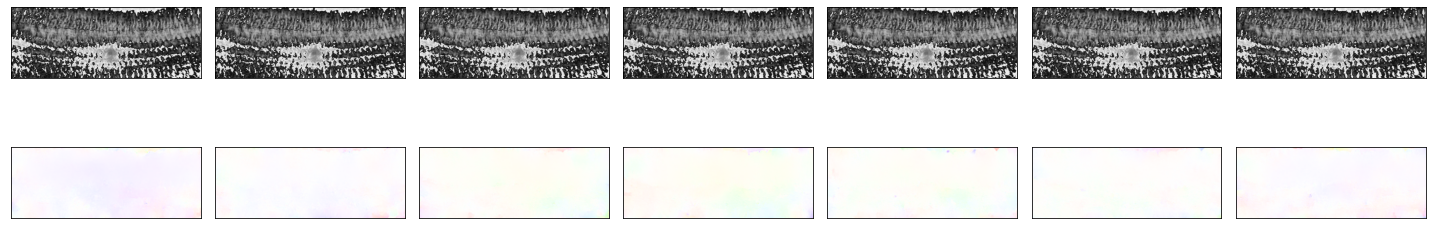

In [136]:
#Setting up for a for loop:
gridlist=[]

for i in range(1): #change to range(1) to only run once
  #we'll end up with seven of these for im1 + im2, im2 + im3, etc...
  img1_batch=img_totensor(i)
  img2_batch=img_totensor(i+1)
  img3_batch = torch.stack([img_totensor(i), img_totensor(i+1), img_totensor(i+2), img_totensor(i+3), img_totensor(i+4), img_totensor(i+5), img_totensor(i+6)])
  img4_batch = torch.stack([img_totensor(i+1), img_totensor(i+2), img_totensor(i+3), img_totensor(i+4), img_totensor(i+5), img_totensor(i+6), img_totensor(i+7)])

  def preprocess(batch):
      transforms = T.Compose(
          [
              T.ConvertImageDtype(torch.float32),
              T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
              T.Resize(size=(600, 1600)),
          ]
      )
      batch = transforms(batch)
      return batch


  # If you can, run this example on a GPU, it will be a lot faster.
  device = "cuda" if torch.cuda.is_available() else "cpu"

  img1_batch_t = preprocess(img3_batch).to(device)
  img2_batch_t = preprocess(img4_batch).to(device)

  #print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

  img1_batch_t = img1_batch_t.repeat(1,3,1,1)
  img2_batch_t = img2_batch_t.repeat(1,3,1,1)
  #print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
  #img1_batch_t=img1_batch_t[None,:, :,:]
  #img2_batch_t=img2_batch_t[None,:, :,:]

  #print(f"shape = {img1_batch_t.shape}, dtype = {img1_batch_t.dtype}")
  #print(f"shape = {img2_batch_t.shape}, dtype = {img2_batch_t.dtype}")

  #print(f"shape = {img2_batch.shape}, dtype = {img2_batch.dtype}")
  model = raft_small(pretrained=True, progress=False).to(device)
  #model_summary(model)
  #model_vals=[layer for layer in model.parameters()]
  #print(model_vals)
  #print(model.parameters)
  model = model.eval()
  with torch.no_grad():
    list_of_flows = model(img1_batch_t.to(device), img2_batch_t.to(device))
    #print(f"type = {type(list_of_flows)}")
    #print(f"length = {len(list_of_flows)} = number of iterations of the model")
    predicted_flows = list_of_flows[-1]
    #print(f"dtype = {predicted_flows.dtype}")
    #print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
    #print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

    flow_imgs = flow_to_image(predicted_flows)

    # The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
    img1_batch = [(img1 + 1) / 2 for img1 in img1_batch_t]

    grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
    #grid = [img1_batch[0], flow_imgs[0]]
    gridlist.append(grid)
    #plot(grid)
    
  for i in range(len(grid)):
    grid = [img1_batch[i], flow_imgs[i]]
    #plot(grid)
    gridlist.append(grid)
  #grid=[img1_batch[0+1], flow_imgs[0+1]]
  #gridlist.append(grid)

transposed_tuples = list(zip(*gridlist[0]))
transposed = [list(sublist) for sublist in transposed_tuples]


plt.rcParams["figure.figsize"] = (20,5)
plot(transposed)

#plot(gridlist)

#Freeing up GPU help
#https://stackoverflow.com/questions/55788093/how-to-free-gpu-memory-by-deleting-tensors
#https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879

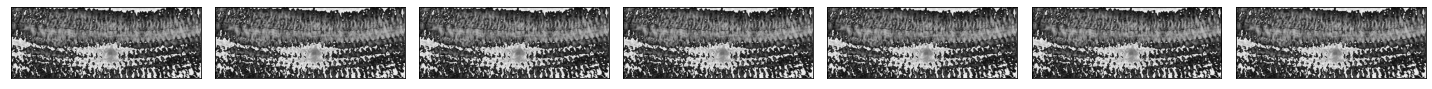

In [137]:
plt.rcParams["figure.figsize"] = (20,5)
plot(transposed[0])

In [138]:
del model #didn't help?
del img1_batch_t #didn't help?
del img2_batch_t #didn't help?
del list_of_flows #didn't help?
#for some reason this works more reliably with a pause
import time
time.sleep(1)
torch.cuda.empty_cache()


In [140]:
!nvidia-smi

Tue Apr  5 13:02:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    41W / 250W |   2475MiB / 16280MiB |     59%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [141]:
#!kill process_id 0

In [142]:
#torch.cuda.empty_cache

In [143]:
#%reset
#print(type(grid))